# Setup

This Colab uses the wine quality dataset<sup>[1]</sup>, which is hosted at [UCI](https://archive.ics.uci.edu/ml/datasets/wine+quality). This dataset contains data on the physicochemical properties of wine along with wine quality ratings. The problem is to predict wine quality (0-10) from physicochemical properties.

In [1]:
from os.path import join
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.2f}'.format

In [3]:
wineDf = pd.read_csv('https://download.mlcc.google.com/mledu-datasets/winequality.csv',
                     encoding='latin-1')
wineDf.columns = ['fixed acidity','volatile acidity','citric acid',
                  'residual sugar','chlorides','free sulfur dioxide',
                  'total sulfur dioxide','density','pH',
                  'sulphates','alcohol','quality']

wineDf.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.00,0.27,0.36,20.70,0.04,45.00,170.00,1.00,3.00,0.45,8.80,6
1,6.30,0.30,0.34,1.60,0.05,14.00,132.00,0.99,3.30,0.49,9.50,6
2,8.10,0.28,0.40,6.90,0.05,30.00,97.00,1.00,3.26,0.44,10.10,6
3,7.20,0.23,0.32,8.50,0.06,47.00,186.00,1.00,3.19,0.40,9.90,6
4,7.20,0.23,0.32,8.50,0.06,47.00,186.00,1.00,3.19,0.40,9.90,6


# Check Correlation Matrix

Before developing your ML model, you need to select features. To find informative features, check the correlation matrix by running the following cell. Which features are informative?

<AxesSubplot:>

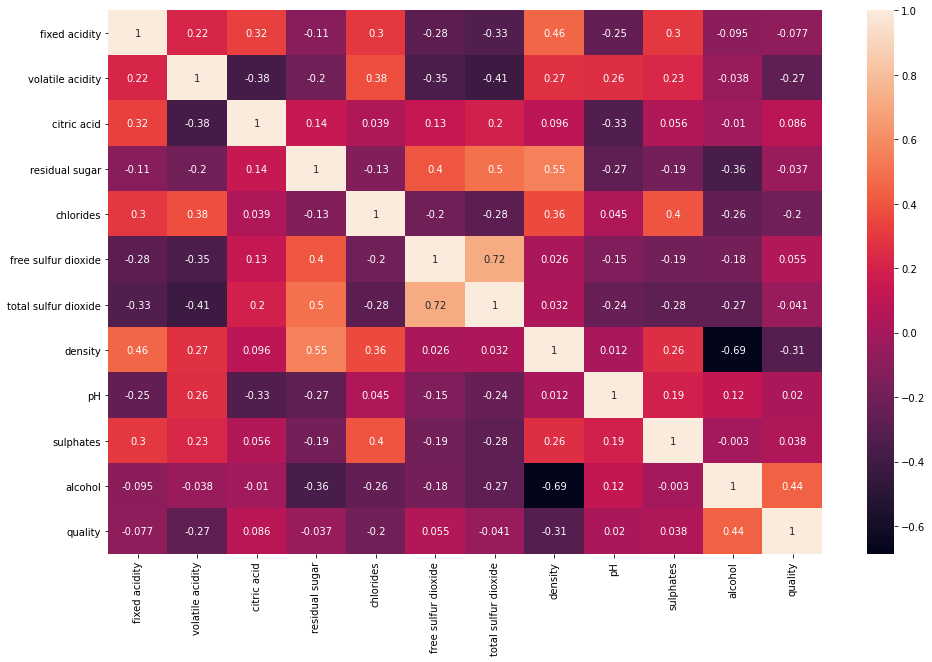

In [4]:
corr_wineDf = wineDf.corr()
plt.figure(figsize=(16,10))
sns.heatmap(corr_wineDf, annot=True)

<span style='color:red'>alcohol</span> is most highly correlated with `quality`. Looking for other informative features, notice that <span style='color:red'>volatile acidity</span> correlates with `quality` but not with `alcohol`, making it a good second feature. Remember that a correlation matrix is not helpful if predictive signals are encoded in combinations of features.

# Validate Input Data against Data Schema

Before processing your data, you should validate the data against a data schema as described in [Data and Feature Debugging](https://developers.google.com/machine-learning/testing-debugging/common/data-errors).

First, define a function that validates data against a schema.

In [5]:
# Define function to validate data
def test_data_schema(input_data, schema):
    """Tests that the datatypes and ranges of values in the dataset
        adhere to expectations.

        Args:
          input_function: Dataframe containing data to test
          schema: Schema which describes the properties of the data.
    """
    def test_dtypes():
        for column in schema.keys():
            assert input_data[column].map(type).eq(schema[column]['dtype']).all(),(
                'Incorrect dtype in column "%s",' %column)
        print('Input dtypes are correct')
        
    def test_ranges():
        for column in schema.keys():
            schema_max = schema[column]['range']['max']
            schema_min = schema[column]['range']['min']
            # Assert that data falls between schema min and max.
            assert input_data[column].max() <= schema_max, (
            "Maximum value of column '%s' is too low." %column)
            assert input_data[column].min() >= schema_min, (
            "Minimum value of column '%s' is too high." %column)
        print('Data falls within specified ranges')
    
    test_dtypes()
    test_ranges()

In [6]:
wineDf.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00
mean,7.22,0.34,0.32,5.44,0.06,30.53,115.74,0.99,3.22,0.53,10.49,5.82
std,1.30,0.16,0.15,4.76,0.04,17.75,56.52,0.00,0.16,0.15,1.19,0.87
min,3.80,0.08,0.00,0.60,0.01,1.00,6.00,0.99,2.72,0.22,8.00,3.00
25%,6.40,0.23,0.25,1.80,0.04,17.00,77.00,0.99,3.11,0.43,9.50,5.00
50%,7.00,0.29,0.31,3.00,0.05,29.00,118.00,0.99,3.21,0.51,10.30,6.00
75%,7.70,0.40,0.39,8.10,0.07,41.00,156.00,1.00,3.32,0.60,11.30,6.00
max,15.90,1.58,1.66,65.80,0.61,289.00,440.00,1.04,4.01,2.00,14.90,9.00


Using the statistics generated above, define the data schema in the following code cell. For demonstration purposes, restrict your data schema to the first three data columns. For each data column, enter the:

 * minimum value
 * maximum value
 * data type

As an example, the values for the first column are filled out. After entering the values, run the code cell to confirm that your input data matches the schema.

In [7]:
wine_schema = {
    'fixed acidity': {
        'range': {
            'min': 3.8,
            'max': 15.9
        },
        'dtype': float,
    },
    'volatile acidity': {
        'range': {
            'min': 0.08,
            'max': 1.58
        },
        'dtype': float,
    },
    'citric acid': {
        'range':{
            'min': 0.,
            'max': 1.66
        },
        'dtype': float
    }
}

print('Validating wine data against data schema...')
test_data_schema(wineDf, wine_schema)

Validating wine data against data schema...
Input dtypes are correct
Data falls within specified ranges


In [8]:
wineDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 609.2 KB


# Split and Normalize Data

Split the dataset into data and labels.

In [9]:
'''
wineFeatures = wineDf.copy(deep=True)
wineFeatures.drop(columns='quality', inplace=True)
wineLabels = wineDf['quality'].copy(deep=True)
'''
wineFeatures = wineDf.copy(deep=True)
wineLabels = wineFeatures.pop('quality')

Normalize data using z-score.

In [10]:
def normalizeData(arr):
    stdArr = np.std(arr)
    meanArr = np.mean(arr)
    arr = (arr-meanArr)/stdArr
    return arr

for str1 in wineFeatures.columns:
    wineFeatures[str1] = normalizeData(wineFeatures[str1])

In [11]:
wineFeatures.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,-0.17,-0.42,0.28,3.21,-0.31,0.82,0.96,2.10,-1.36,-0.55,-1.42
1,-0.71,-0.24,0.15,-0.81,-0.20,-0.93,0.29,-0.23,0.51,-0.28,-0.83
2,0.68,-0.36,0.56,0.31,-0.17,-0.03,-0.33,0.13,0.26,-0.61,-0.33
3,-0.01,-0.67,0.01,0.64,0.06,0.93,1.24,0.30,-0.18,-0.88,-0.50
4,-0.01,-0.67,0.01,0.64,0.06,0.93,1.24,0.30,-0.18,-0.88,-0.50


# Test Engineered Data
After normalizing your data, you should test your engineered data for errors as described in [Data and Feature Debugging](https://developers.google.com/machine-learning/testing-debugging/common/data-errors). In this section, you will test that engineering data:

* Has the expected number of rows and columns.
* Does not have null values.

First, set up the testing functions by running the following code cell:

In [12]:
wineFeatures.info(), wineLabels.describe(), wineLabels.notnull() # find not-null in Series

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
dtypes: float64(11)
memory usage: 558.5 KB


(None,
 count   6497.00
 mean       5.82
 std        0.87
 min        3.00
 25%        5.00
 50%        6.00
 75%        6.00
 max        9.00
 Name: quality, dtype: float64,
 0       True
 1       True
 2       True
 3       True
 4       True
         ... 
 6492    True
 6493    True
 6494    True
 6495    True
 6496    True
 Name: quality, Length: 6497, dtype: bool)

In [13]:
import unittest

def test_input_dim(df, n_rows, n_columns):
    assert len(df) == n_rows, "Unexpected number of rows"
    assert len(df.columns) == n_columns, "Unexpected number of columns"
    print('Engineering data has the expected number of rows and columns.')
    
def test_nulls(df):
    dataNulls = df.isnull().sum().sum()
    assert dataNulls == 0, "Nulls in engineering data"
    print('Engineered features do not contain nulls')

In [14]:
wineFeatures.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
                       ..
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
Length: 11, dtype: int64

In [15]:
# Test dimensions of engineered data
wine_feature_rows = 6497
wine_feature_cols = 11 
test_input_dim(wineFeatures,
               wine_feature_rows,
               wine_feature_cols)

Engineering data has the expected number of rows and columns.


In [16]:
test_nulls(wineFeatures)

Engineered features do not contain nulls


# Check Splits for Statistical Equivalence

As described in the [Data Debugging](https://developers.google.com/machine-learning/testing-debugging/common/data-errors) guidelines, before developing your model, you should check that your training and validation splits are equally representative. Assuming a training:validation split of 80:20, compare the mean and the standard deviation of the splits by running the next two code cells. Note that this comparison is not a rigorous test for statistical equivalence but simply a quick and dirty comparison of the splits.

In [17]:
int(wineFeatures.shape[0]*8/10 + 0.5)

5198

In [18]:
splitIdx = int(wineFeatures.shape[0]*8/10 + 0.5) # split Idx (capital I)dx == index(Idx)
wineFeatures.iloc[:splitIdx].describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,5198.00,5198.00,5198.00,5198.00,5198.00,5198.00,5198.00,5198.00,5198.00,5198.00,5198.00
mean,-0.23,-0.28,0.07,0.15,-0.21,0.20,0.32,-0.17,-0.14,-0.20,-0.01
std,0.72,0.76,0.88,1.05,0.86,0.98,0.82,1.00,0.96,0.90,1.02
min,-2.63,-1.58,-2.19,-1.02,-1.34,-1.61,-1.91,-2.53,-3.10,-2.09,-2.09
25%,-0.71,-0.79,-0.40,-0.78,-0.57,-0.48,-0.23,-0.97,-0.80,-0.82,-0.92
50%,-0.32,-0.42,-0.06,-0.14,-0.34,0.11,0.27,-0.23,-0.24,-0.34,-0.16
75%,0.14,0.00,0.49,0.85,-0.12,0.82,0.87,0.60,0.44,0.19,0.68
max,6.01,6.02,9.23,12.69,15.84,14.56,5.74,14.77,4.24,9.87,3.11


In [19]:
wineFeatures.iloc[splitIdx:].describe() # 20%의 통계

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1299.00,1299.00,1299.00,1299.00,1299.00,1299.00,1299.00,1299.00,1299.00,1299.00,1299.00
mean,0.91,1.11,-0.27,-0.61,0.83,-0.82,-1.27,0.67,0.55,0.80,0.05
std,1.38,1.08,1.34,0.31,1.10,0.61,0.56,0.66,0.96,0.99,0.90
min,-1.79,-1.33,-2.19,-0.95,-1.26,-1.66,-1.94,-1.54,-2.23,-1.08,-1.75
25%,-0.09,0.31,-1.50,-0.74,0.37,-1.33,-1.68,0.25,-0.05,0.13,-0.75
50%,0.61,1.03,-0.33,-0.68,0.66,-0.93,-1.43,0.65,0.51,0.60,-0.08
75%,1.69,1.81,0.77,-0.60,0.97,-0.48,-1.00,1.07,1.13,1.30,0.68
max,6.70,7.53,3.24,2.11,10.45,2.34,3.07,3.00,4.92,7.32,3.70


80% 데이터 결과와 20% 데이터 결과의 각 column의  <span style='color:red'>평균, 표준편차의 차이가 크게 나타남.</span> <br>
The two splits are clearly not equally representative. To make the splits equally representative, you can shuffle the data.

Run the following code cell to shuffle the data, and then recreate the features and labels from the shuffled data.

In [20]:
# Shuffle data
wineDf = wineDf.sample(frac=1)
wineDf.reset_index(drop=True) # index numbering을 0부터 재 부여. drop=True: 기존 index number를 delete
# Recreate feature and labels
wineFeatures = wineDf.copy(deep=True)
wineLabels = wineFeatures.pop('quality')

# Establish a Baseline
For a regression problem, the simplest baseline to predict the average value. Run the following code to calculate the mean-squared error (MSE) loss on the training split using the average value as a baseline. Your loss is approximately 0.75. Any model should beat this loss to justify its use.

In [21]:
baselineMSE = np.square(wineLabels[0:splitIdx] - np.mean(wineLabels[0:splitIdx]))
baselineMSE = np.sum(baselineMSE)/len(baselineMSE)
print(baselineMSE)

0.777129074564891


# Linear Model (use only one feature column to start!)

Following good ML dev practice, let's start with a linear model that uses the most informative feature from the correlation matrix: `alcohol`. Even if this model performs badly, we can still use it as a baseline. This model should beat our previous baseline's MSE of 0.75.

First, let's define a function to plot our loss and accuracy curves. The function will also print the final loss and accuracy. Instead of using `verbose=1`, you can call the function.

In [22]:
def showRegressionResults(trainHistory):
    # Print final loss
    print('Final training loss:' + str(trainHistory.history['loss'][-1]))
    print('Final validation loss:' + str(trainHistory.history['val_loss'][-1])) 
    plt.figure(figsize=(8,5))
    loss = trainHistory.history['loss']
    val_loss = trainHistory.history['val_loss']
    epochs = trainHistory.epoch
    plt.plot(epochs, loss, '-ro')
    plt.plot(epochs, val_loss, ':b+')
    plt.legend(['Training loss', 'Validation loss'], loc='best')
    plt.title('Loss Curves')

For fast prototyping, let's try using a full batch per epoch to update the gradient only once per  epoch. Use the full batch by setting `batch_size = wineFeatures.shape[0]` as indicated by the code comment.

Final training loss:8.161182403564453
Final validation loss:7.8668131828308105


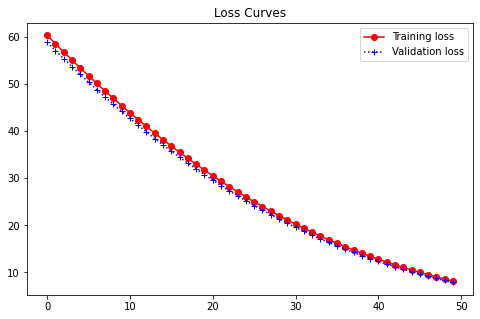

In [23]:
wineFeatureSelected = wineFeatures['alcohol']

model = None

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=1, activation='linear', input_dim=1))
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))
trainHistory = model.fit(wineFeatureSelected, wineLabels, batch_size=len(wineLabels), epochs=50, 
                        validation_split=0.2, verbose=0)

showRegressionResults(trainHistory)

The loss decreases but very slowly. Possible fixes are:

* Increase number of epochs.
* Increase learning rate.
* Decrease batch size. A lower batch size can result in larger decrease in loss per epoch, under the assumption that the smaller batches stay representative of the overall data distribution.

Play with these three parameters in the code above to decrease the loss.

Final training loss:0.6503302454948425
Final validation loss:0.5999253392219543


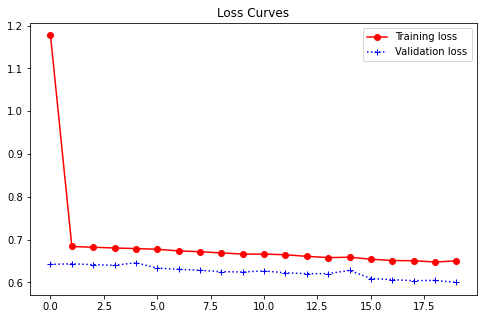

In [24]:
# just change batch_size to 100
wineFeatureSelected = wineFeatures['alcohol']

model = None

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=1, activation='linear', input_dim=1))
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))
trainHistory = model.fit(wineFeatureSelected, wineLabels, batch_size=100, epochs=20, 
                        validation_split=0.2, verbose=0)

showRegressionResults(trainHistory)

Run the following code cell to train the model using a <span style='color:red'>reduced batch size of 100</span>. Reducing the batch size leads to a greater decrease in loss per epoch. The minimum achievable loss is about <span style='color:red'>0.64. This is a significant increase over our baseline of 0.75.</span>

# Add Feature to Linear Model

Try adding a feature to the linear model. Since you need to combine the two features into one prediction for regression, you'll also need to add a second layer. Modify the code below to implement the following changes:

1. Add `'volatile acidity'` to the features in `wineFeaturesSimple`.
1. Add a second linear layer with 1 unit.
1. Experiment with learning rate, epochs, and batch_size to try to reduce loss.

What happens to your loss?

Final training loss:0.579509437084198
Final validation loss:0.5397416353225708


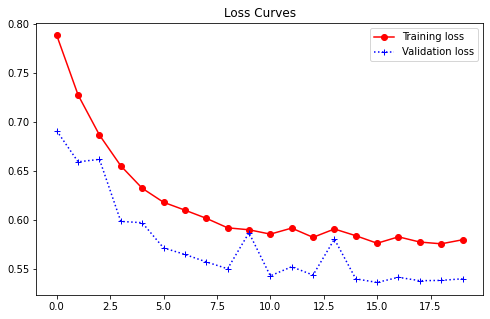

In [25]:
# add one more feature
wineFeatureSelected = wineFeatures[['alcohol', 'volatile acidity']]
in_dim = wineFeatureSelected.shape[1]
n_node = in_dim # 처음에는 layer node 수는 특성열 갯수와 동일하게 시작. 후에 결과를 보면서 조정

model = None

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=n_node, activation='linear', input_dim=in_dim))
model.add(tf.keras.layers.Dense(1, activation='linear'))
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))
trainHistory = model.fit(wineFeatureSelected, wineLabels, 
                         batch_size=100, epochs=20, validation_split=0.2, verbose=0)

showRegressionResults(trainHistory)

# Use a Nonlinear Model

Let's try a nonlinear model. Modify the code below to make the following changes:

1. Change the first layer to use `relu`. (<span style='color:red'>Output layer stays linear since this is a regression problem.</span>)
1. As usual, specify the learning rate, epochs, and batch_size.

Run the cell. Does the loss increase, decrease, or stay the same?

Final training loss:0.6151139140129089
Final validation loss:0.5747257471084595


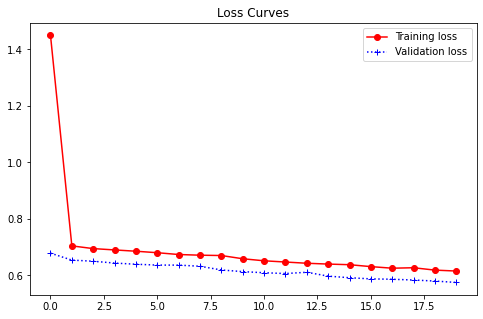

In [26]:
# change activation 
wineFeatureSelected = wineFeatures[['alcohol', 'volatile acidity']]
in_dim = wineFeatureSelected.shape[1]
n_node = in_dim # 처음에는 layer node 수는 특성열 갯수와 동일하게 시작. 후에 결과를 보면서 조정

model = None

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=n_node, activation='relu', input_dim=in_dim))
model.add(tf.keras.layers.Dense(1, activation='linear'))
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))
trainHistory = model.fit(wineFeatureSelected, wineLabels, 
                         batch_size=100, epochs=20, validation_split=0.2, verbose=0)

showRegressionResults(trainHistory)

# Optimize Your Model

We have two features with one hidden layer but didn't see an improvement. At this point, it's tempting to use all your features with a high-capacity network. However, you must resist the temptation. Instead, follow the guidance in [Model Optimization](https://developers.google.com/machine-learning/testing-debugging/common/optimization) to improve model performance. For a hint and for a discussion, see the following text sections.

Final training loss:0.5743517875671387
Final validation loss:0.5318405628204346


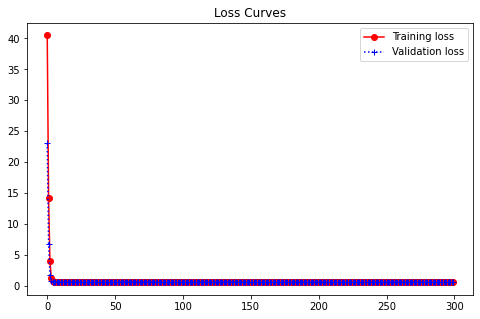

In [27]:
# add one more feature
wineFeatureSelected = wineFeatures[['alcohol', 'volatile acidity', 'density', 'chlorides']]
in_dim = wineFeatureSelected.shape[1]
n_node = in_dim # 처음에는 layer node 수는 특성열 갯수와 동일하게 시작. 후에 결과를 보면서 조정

model = None

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=n_node, activation='relu', input_dim=in_dim))
model.add(tf.keras.layers.Dense(1, activation='linear'))
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam())
trainHistory = model.fit(wineFeatureSelected, wineLabels, 
                         batch_size=100, epochs=300, validation_split=0.2, verbose=0)

showRegressionResults(trainHistory)

Your loss reduces to about 0.56. That's a minor improvement over the previous loss of 0.58. It seems that adding more features or capacity isn't improving your model by much. Perhaps your model has a bug? In the next section, you will run a sanity check on your model.

# Check for Implementation Bugs using Reduced Dataset

Your loss isn't decreasing by much. Perhaps your model has an implementation bug. From the [Model Debugging](https://developers.google.com/machine-learning/testing-debugging/common/model-errors) guidelines, a quick test for implementation bugs is to obtain a low loss on a reduced dataset of, say, 10 examples. Remember, passing this test does not validate your modeling approach but only checks for basic implementation bugs. In your ML problem, if your model passes this test, then continue debugging your model to train on your full dataset.

In the following code, experiment with the learning rate, batch size, and number of epochs. Can you reach a low loss? Choose hyperparameter values that let you iterate quickly.

Final training loss:0.3575061857700348
Final validation loss:0.9661902189254761


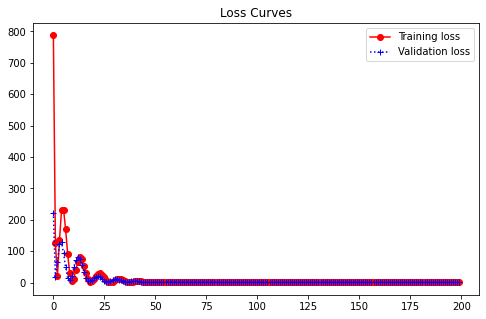

In [30]:
# use small number of samples say 10 examples 
wineFeatureSelected = wineFeatures.iloc[0:10]
# wineFeatureSelected = wineFeatureSelected[['alcohol', 'volatile acidity', 'density', 'chlorides']]
wineLabelSelected = wineLabels[0:10]
in_dim = wineFeatureSelected.shape[1]
n_node = in_dim # 처음에는 layer node 수는 특성열 갯수와 동일하게 시작. 후에 결과를 보면서 조정

model = None

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=n_node, activation='relu', input_dim=in_dim))
model.add(tf.keras.layers.Dense(units=n_node, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='linear'))
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(0.01))
trainHistory = model.fit(wineFeatureSelected, wineLabelSelected, 
                         batch_size=10, epochs=200, validation_split=0.2, verbose=0)

showRegressionResults(trainHistory)

# Trying a Very Complex Model
Let's go all in and use a very complex model with all the features. For science! And to satisfy ourselves that a simple model is indeed better. Let's use all 11 features with 3 fully-connected relu layers and a final linear layer. The next cell takes a while to run. Skip to the results in the cell after if you like.

Final training loss:0.5539884567260742
Final validation loss:0.6087650656700134


(0.4, 1.0)

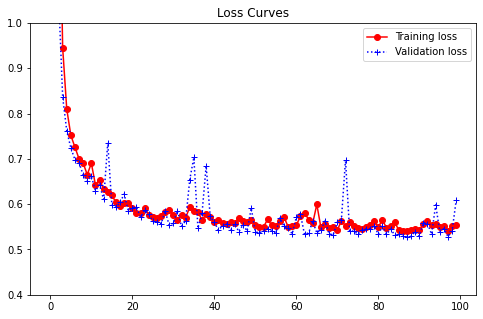

In [29]:
in_dim = wineFeatures.shape[1]
n_node = in_dim # 처음에는 layer node 수는 특성열 갯수와 동일하게 시작. 후에 결과를 보면서 조정

model = None

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=n_node, activation='relu', input_dim=in_dim))
model.add(tf.keras.layers.Dense(units=n_node, activation='relu'))
model.add(tf.keras.layers.Dense(units=n_node, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='linear'))
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam())
trainHistory = model.fit(wineFeatures, wineLabels, 
                         batch_size=100, epochs=100, validation_split=0.2, verbose=0)

showRegressionResults(trainHistory)
plt.ylim(0.4,1)